## Intensity filtered data using reference aluminium wavelength 309.506 (pixel number 445) using saturated data

### No preprocessing

In [1]:
import os
from sys import stdout
import time


import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peakutils
%matplotlib inline 
from math import sqrt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.linear_model import ElasticNet,ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
    mse = []
    component = np.arange(1, n_comp)
    for i in component:
        pls = PLSRegression(n_components=i)
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
        mse.append(mean_squared_error(y, y_cv))
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
        plt.show()
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
    
    return
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
"""   
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Brix')
        plt.ylabel('Measured $^{\circ}$Brix')
        plt.show()
    return
""" 

"   \n    # Fit a line to the CV vs response\n    z = np.polyfit(y, y_c, 1)\n    with plt.style.context(('ggplot')):\n        fig, ax = plt.subplots(figsize=(9, 5))\n        ax.scatter(y_c, y, c='red', edgecolors='k')\n        #Plot the best fit line\n        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)\n        #Plot the ideal 1:1 line\n        ax.plot(y, y, color='green', linewidth=1)\n        plt.title('$R^{2}$ (CV): '+str(score_cv))\n        plt.xlabel('Predicted $^{\\circ}$Brix')\n        plt.ylabel('Measured $^{\\circ}$Brix')\n        plt.show()\n    return\n"

In [3]:
def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
    Xc = X[:,sorted_ind]
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [4]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

In [5]:
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        data_snv[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    return data_snv

In [6]:
x_df = pd.read_csv('../avg_base_wl_max_28-02.csv', sep = ',')
values = x_df.values
#wl=x_df.columns.values
#print(wl.shape)

#print(values)
#print(type(values))
print(values.shape)
print(values[1].shape)
print(len(values))
x_df

(34, 3648)
(3648,)
34


,216.330000,216.370000,216.410000,216.450000,216.490000,216.520000,216.560000,216.600000,216.640000,216.680000,...,340.120000,340.150000,340.170000,340.200000,340.230000,340.260000,340.290000,340.320000,340.340000,340.370000
0,-0.000971,-0.001513,-0.001537,-0.001446,-0.001329,-0.001400,-0.001263,-0.001237,-0.000737,-0.000370,...,-0.002839,-0.000734,-0.000576,-0.000206,-0.000487,-0.001280,-0.001555,-0.001104,-0.000473,0.000150
1,-0.000990,-0.001709,-0.001716,-0.001646,-0.001491,-0.001544,-0.001405,-0.001372,-0.000814,-0.000230,...,-0.001933,0.000642,0.000811,0.001411,0.001043,-0.000176,-0.000374,0.000230,0.001008,0.001834
2,-0.001592,-0.002231,-0.002187,-0.002158,-0.001942,-0.002038,-0.001832,-0.001680,-0.001126,-0.000577,...,-0.002332,0.000094,0.000096,0.000830,0.000328,-0.000598,-0.000636,-0.000052,0.000606,0.001288
3,-0.001974,-0.002943,-0.003067,-0.002909,-0.002360,-0.002542,-0.002514,-0.002261,-0.001045,0.000931,...,-0.000994,0.003097,0.003858,0.005618,0.005193,0.002781,0.002060,0.003184,0.004883,0.007010
4,-0.001142,-0.001877,-0.001925,-0.001809,-0.001632,-0.001676,-0.001559,-0.001483,-0.000802,0.000155,...,-0.002026,0.000788,0.001041,0.001845,0.001382,0.000046,-0.000481,0.000249,0.001247,0.002534
5,-0.000938,-0.001583,-0.001570,-0.001434,-0.001293,-0.001331,-0.001358,-0.001198,-0.000701,-0.000019,...,-0.002130,0.000412,0.000556,0.001274,0.000812,-0.000362,-0.000793,-0.000154,0.000755,0.001812
6,-0.000998,-0.001702,-0.001706,-0.001602,-0.001437,-0.001505,-0.001444,-0.001327,-0.000698,0.000155,...,-0.001986,0.000813,0.000923,0.001931,0.001455,0.000075,-0.000376,0.000339,0.001332,0.002633
7,-0.000964,-0.001628,-0.001651,-0.001606,-0.001379,-0.001506,-0.001420,-0.001316,-0.000685,-0.000009,...,-0.002142,0.000723,0.000727,0.001589,0.001066,-0.000237,-0.000648,-0.000006,0.000929,0.002168
8,-0.001282,-0.002357,-0.002454,-0.002377,-0.001970,-0.002121,-0.001991,-0.001933,-0.000961,0.000014,...,-0.002514,0.001364,0.001986,0.003405,0.003099,0.001087,0.000439,0.001331,0.002886,0.004573
9,-0.000980,-0.001509,-0.001562,-0.001450,-0.001318,-0.001345,-0.001296,-0.001159,-0.000637,0.000038,...,-0.001978,0.000265,0.000265,0.000955,0.000591,-0.000356,-0.000618,-0.000048,0.000647,0.001534


[[216.33]
 [216.37]
 [216.41]
 ...
 [340.32]
 [340.34]
 [340.37]]


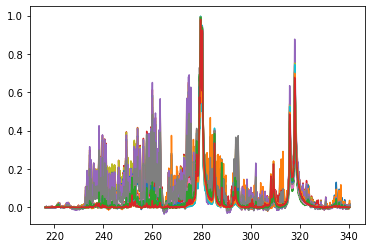

In [7]:
#This is just for visualizing the various plots of the samples

mat = scipy.io.loadmat("../data/H01.mat")
wl= mat["wl"]
print(wl)

for i in range(len(values)):
    plt.plot(wl, values[i])
    #plt.show() #comment this one to have unique plot instead of multiple ones
#range(len(dfs))
#"""




In [8]:
df_y = pd.read_csv('../concentration.csv', sep = ',')
print(type(df_y))
concentration=df_y.values
print(concentration.shape)
#print(concentration)

y_values=df_y.values
#y_all=pd.DataFrame(y_values[:,1:-2])
#print(y_all)
df_y

<class 'pandas.core.frame.DataFrame'>
(34, 12)


,Sample,CaO,CaF2,MgO,Al2O3,SiO2,FeO,MnO,Cr2O3,P2O5,V2O5,TiO2
0,H01,37.8,0.18,25.00,9.61,13.20,18.30,1.99,0.20,0.23,0.18,1.03
1,H02,44.5,0.22,18.00,5.04,14.20,18.90,2.10,0.28,0.26,0.06,1.07
2,H03,38.5,0.22,21.10,6.14,10.60,20.20,5.82,0.61,0.40,0.14,0.86
3,H04,38.4,0.04,15.50,4.07,12.80,26.70,3.35,0.52,0.31,0.08,1.07
4,H05,43.2,0.18,17.10,4.14,14.80,21.70,1.72,0.20,0.29,0.18,1.07
5,H06,45.3,0.23,15.90,4.34,16.50,18.90,1.29,0.10,0.30,0.11,1.10
6,H07,46.1,0.25,14.30,4.12,16.20,19.00,1.21,0.09,0.27,0.06,1.08
7,H08,45.1,0.19,13.00,4.05,16.10,21.00,1.26,0.10,0.28,0.06,1.09
8,H09,32.8,0.01,10.60,7.30,14.30,33.20,2.75,0.42,0.32,0.09,1.12
9,H10,42.4,0.24,19.30,6.50,14.70,17.40,2.72,0.31,0.28,0.09,1.06


In [120]:
y_val = concentration[:,5] #3-Mg, 4-Al, 5-Si, 6-Fe, 7-Mn
print(y_val)
print(y_val.shape)
y_df= pd.DataFrame(y_val)
#y_df

[13.2 14.2 10.6 12.8 14.8 16.5 16.2 16.1 14.3 14.7 14.0 12.8 33.3 35.3
 35.3 29.0 34.3 34.5 32.5 30.9 27.8 25.3 24.3 21.5 5.85 25.4 28.0 13.9
 11.6 11.8 28.5 5.99 27.5 7.54]
(34,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(27, 3648) (27, 1)
(7, 3648) (7, 1)
       0
13   7.9
14   9.6
8   10.6
28   8.9
32    20
3   15.5
0     25


# Principal Components Analysis

In [12]:
n_components=25


x = x_df.values
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

principalComponents = pca.fit_transform(X_std)
print(principalComponents.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
#print(pca.singular_values_)

(34, 3648)
(3648,)
34
(34, 25)
[53.58 77.76 85.12 91.31 93.68 95.42 96.48 97.47 98.17 98.75 99.   99.23
 99.41 99.55 99.65 99.72 99.78 99.83 99.87 99.91 99.93 99.94 99.95 99.96
 99.97]


In [13]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(principalComponents, y_df)
# Calibration
y_c = regr.predict(principalComponents)
# Cross-validation
y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_df, y_c)
score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation

mse_c = mean_squared_error(y_df, y_c)
mse_cv = mean_squared_error(y_df, y_cv)

print(score_c, score_cv)
print(mse_c, mse_cv)

0.9073011737744466 -35.84844457394992
2.553587620852715 1015.0692920616232


now using PCA with Linear regression and PLS

In [14]:
n_components=25

x = X_train.values
x_t = X_test.values
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
X_std_test = StandardScaler().fit_transform(x_t)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

x_pc = pca.fit_transform(X_std)
x_test1 = pca.transform(X_std_test)
print(x_pc.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

(27, 3648)
(3648,)
27
(27, 25)
[50.88 76.67 84.88 91.56 94.41 96.33 97.56 98.29 98.72 99.07 99.32 99.52
 99.66 99.74 99.81 99.86 99.89 99.91 99.93 99.94 99.95 99.96 99.97 99.98
 99.98]


In [91]:
x_pc, x_test1, y_train, y_test = train_test_split(principalComponents, y_df, test_size=0.15)

In [92]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(x_pc, y_train)
# Calibration
y_p = regr.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_p)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_p)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2_pred: ", score_c)
print("MSE: ", mse_c)

R2_pred:  -39.569957362196114
MSE:  262.62285732461606


37% completed
Suggested number of components:  8



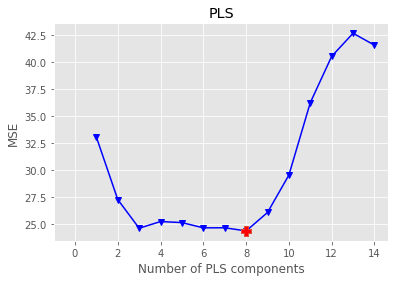

R2 calib: 0.995
R2 CV: 0.241
MSE calib: 0.165
MSE CV: 24.343


In [93]:
optimise_pls_cv(x_pc, y_train, 15, plot_components=True) 

In [94]:
pls = PLSRegression(n_components=8)
# Fit
pls.fit(x_pc, y_train)
# Calibration
y_c = pls.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_c)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_c)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2_pred: ", score_c)
print("MSE: ", mse_c)

R2_pred:  -14.708179040796798
MSE:  101.6842789907579


# Independent Component Analysis

In [109]:
from sklearn.decomposition import FastICA

transformer = FastICA(n_components=20, random_state=0)

X_transformed = transformer.fit_transform(x_df)
X_transformed.shape

(34, 20)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_df, test_size=0.2)

# Linear Regression
this is ordinary least square regression

R^2_pred:  0.9042637436238312
RMSE:  2.262900226575336 

[real, predictions]
[[28.5 26.58226664565476]
 [25.3 20.711730743291312]
 [13.2 11.030138643288979]
 [32.5 31.33135293700897]
 [14.3 12.593927431537367]
 [16.1 17.389577739971294]
 [14.8 15.483650083113492]]


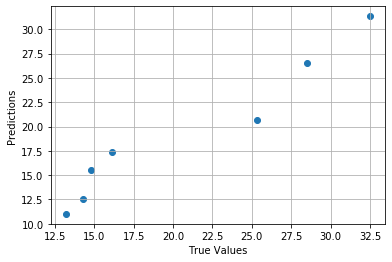

In [167]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)


rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("R^2_pred: ", r2)
print("RMSE: ", rmse, "\n")


b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Partial Least Square Regression

## No preprocessing

In [162]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)
y_test

(27, 3648) (27, 1)
(7, 3648) (7, 1)


,0
30,28.5
21,25.3
0,13.2
18,32.5
8,14.3
7,16.1
4,14.8


100% completed
Suggested number of components:  8



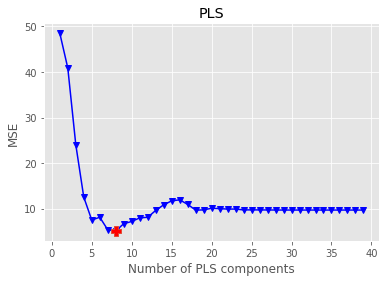

R2 calib: 0.985
R2 CV: 0.940
MSE calib: 1.311
MSE CV: 5.102


In [163]:
optimise_pls_cv(x_df, y_df, 40, plot_components=True)

In [164]:
# Define PLS object
pls = PLSRegression(n_components=6)
# Fit
pls.fit(x_df, y_df)
# Cross-validation
y_cv = cross_val_predict(pls, x_df, y_df, cv=10)
# Calculate scores
score = r2_score(y_df, y_cv)
mse = mean_squared_error(y_df, y_cv)

print("R^2_cv", score)
print("MSE: ", mse)

R^2_cv 0.9049382495916015
MSE:  8.106272711881639


50% completed
Suggested number of components:  8



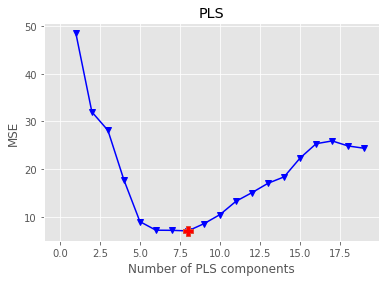

R2 calib: 0.989
R2 CV: 0.925
MSE calib: 1.017
MSE CV: 7.016


In [165]:
optimise_pls_cv(X_train,y_train, 20, plot_components=True)

R2_pred:  0.8955724959501055
R2_cv:  0.9249780099625089

TEST
 [real, predictions]
[[28.5 24.923651005616616]
 [25.3 24.340760946950997]
 [13.2 9.468136002182552]
 [32.5 32.72652462971796]
 [14.3 10.979141908749618]
 [16.1 16.706767389453987]
 [14.8 14.680207621099175]]



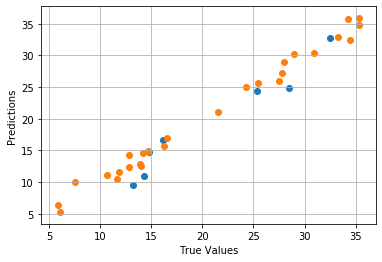

In [166]:
# Define PLS object
pls = PLSRegression(n_components=8)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

In [42]:
print(wl.shape)

(3648, 1)


## Wavelenght selection for PLS

In [121]:
start_time = time.time()

opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_df.values, y_val, 15)

print("--- %s seconds ---" % (time.time() - start_time))

100% completed
Optimised number of PLS components:  7
Wavelengths to be discarded  3600
Optimised MSEP  3.586002585737057

--- 1539.1489548683167 seconds ---


sorted wavelengths:  [[273.04 312.28 235.39 304.01 323.55 245.14 333.51 331.51 336.07 245.06]]


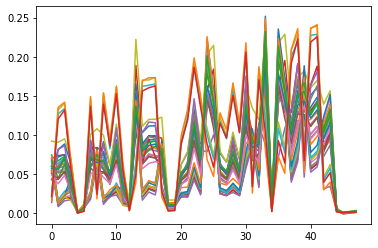

In [185]:
#print(opt_Xc.shape,"\n")
#print("sorted indexes: ", sorted_ind)
print("sorted wavelengths: ", wl[sorted_ind[:10]].T)

plt.plot(opt_Xc.T)
plt.show()

In [181]:
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Mg = 3, 16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Si = 7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Cu =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Fe =7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 3) #seed for Mn = 3

X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(27, 48) (27, 1)
(7, 48) (7, 1)
       0
27  13.9
8   14.3
32  27.5
19  30.9
28  11.6
22  24.3
10    14


75% completed
Suggested number of components:  4



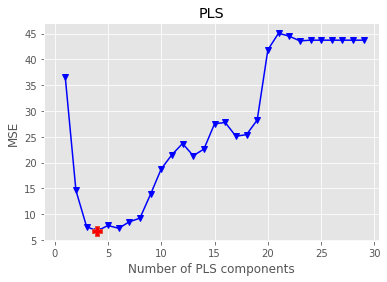

R2 calib: 0.963
R2 CV: 0.927
MSE calib: 3.420
MSE CV: 6.775


In [182]:
optimise_pls_cv(X_train,y_train, 30, plot_components=True)

R2_pred:  0.9349391566422233
RMSE:  1.8495672855432705



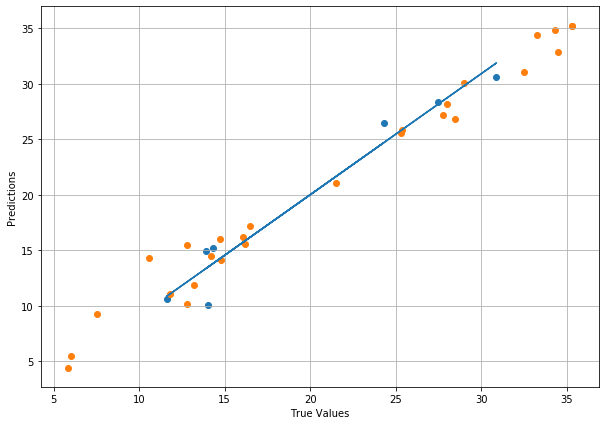

In [183]:
# Define PLS object
pls = PLSRegression(n_components=7)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Normalization

In [171]:
Xn_train = normalize(X_train, axis=1)
Xn_test = normalize(X_test, axis=1)
print(Xn_train.shape)
print(Xn_test.shape)

(27, 48)
(7, 48)


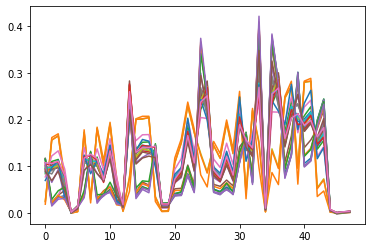

In [172]:
plt.plot(Xn_train.T)
plt.show()

In [173]:
#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
#optimise_pls_cv(Xn_train,y_train, 7, plot_components=True)

R2_pred:  0.9462065976347825
RMSE:  2.384217775176226

TEST
 [real, predictions]
[[27.8 26.928217714916556]
 [34.5 33.768082640957125]
 [21.5 22.214502734356437]
 [7.54 9.433571239753157]
 [5.85 1.479960419385776]
 [10.6 14.484752579107942]
 [25.4 25.859433007919986]]



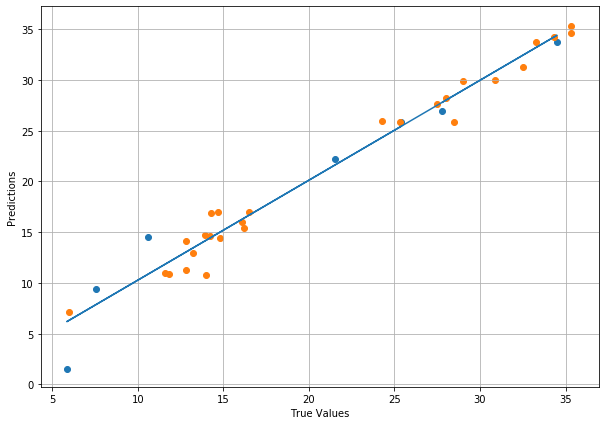

In [174]:
# Define PLS object
pls = PLSRegression(n_components=7)
# Fit
pls.fit(Xn_train, y_train)

y_pred = pls.predict(Xn_test)
y_pred1 = pls.predict(Xn_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using SNV

In [175]:
Xs_train = snv(X_train)
Xs_test = snv(X_test)
print(Xs_train.shape)
print(Xs_test.shape)

#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
#optimise_pls_cv(Xs_train,y_train, 7, plot_components=True)

(27, 48)
(7, 48)


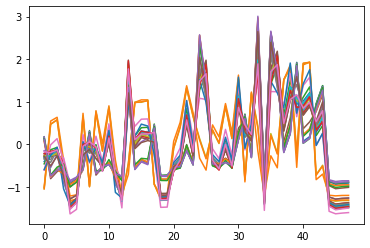

In [176]:
plt.plot(Xs_train.T)
plt.show()

R2_pred:  0.6611370397934027
RMSE:  5.98402590316042

TEST
 [real, predictions]
[[27.8 28.32880277105492]
 [34.5 34.06504978901949]
 [21.5 8.429010585175044]
 [7.54 9.217759226218668]
 [5.85 -2.712882658026576]
 [10.6 12.342928149852286]
 [25.4 25.80589377532698]]



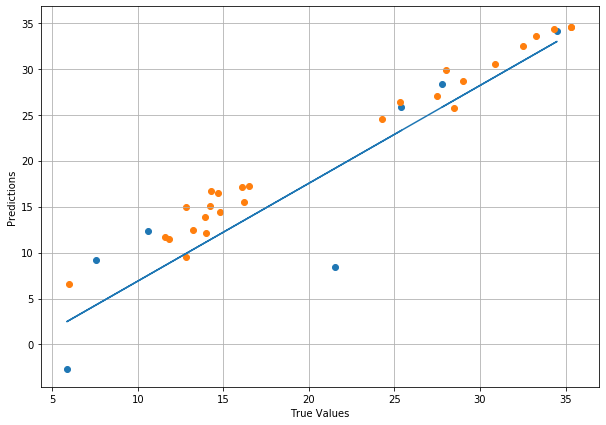

In [177]:
# Define PLS object
pls = PLSRegression(n_components=7)
# Fit
pls.fit(Xs_train, y_train)

y_pred = pls.predict(Xs_test)
y_pred1 = pls.predict(Xs_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Max-norm

In [178]:
Xm_train = X_train / np.max(X_train)
Xm_test = X_test / np.max(X_test)

#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
#optimise_pls_cv(Xm_train,y_train, 15, plot_components=True)

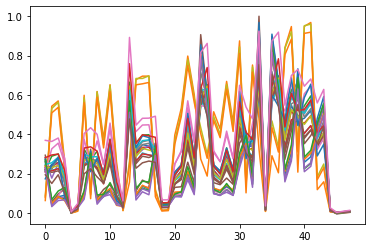

In [179]:
plt.plot(Xm_train.T)
plt.show()

R2_pred:  0.949875271516036
RMSE:  2.3014811975233425

TEST
 [real, predictions]
[[27.8 26.953098746623958]
 [34.5 32.16842313894841]
 [21.5 21.49121191646735]
 [7.54 10.396306656716085]
 [5.85 5.1256738607353824]
 [10.6 15.315723972843662]
 [25.4 25.454328944643382]]



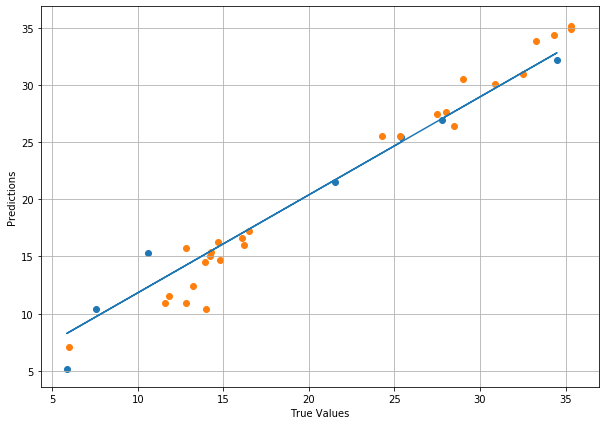

In [180]:
# Define PLS object
pls = PLSRegression(n_components=7)
# Fit
pls.fit(Xm_train, y_train)

y_pred = pls.predict(Xm_test)
y_pred1 = pls.predict(Xm_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Savgol filter

In [33]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(27, 3648) (27, 1)
(7, 3648) (7, 1)


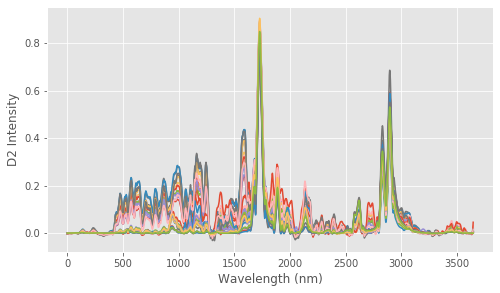

100% completed
Suggested number of components:  6



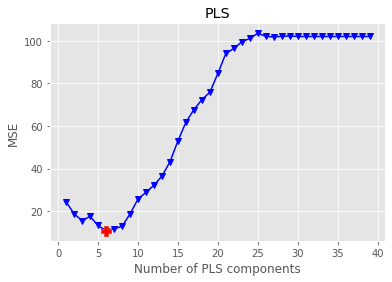

R2 calib: 0.834
R2 CV: 0.609
MSE calib: 4.571
MSE CV: 10.778


In [34]:
# Calculate second derivative
X2 = savgol_filter(x_df, 101, polyorder = 6,deriv=0) # Is this useful with LIBS spectra???
# Plot second derivative
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(range(len(X2.T)), X2.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Intensity')
    plt.show()
    
    
X2_1 = msc(X2)[0]
    
optimise_pls_cv(X2_1, y_df, 40, plot_components=True)

100% completed
Suggested number of components:  5



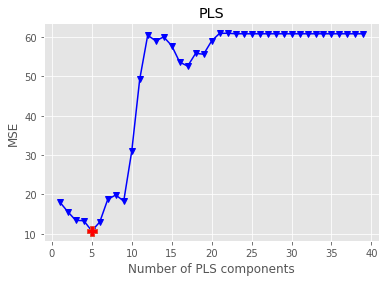

R2 calib: 0.852
R2 CV: 0.581
MSE calib: 3.787
MSE CV: 10.752


In [35]:
X2_train = savgol_filter(X_train, 37, polyorder = 4,deriv=1) 
X2_test = savgol_filter(X_test, 35, polyorder = 4,deriv=1) 




optimise_pls_cv(X2_train, y_train, 40, plot_components=True)

R2_pred:  0.1649860006265983
R2_cv:  0.4927830298446778

[real, predictions]
[[15.9 10.770687549143025]
 [13.0 14.465004698889048]
 [7.2 -1.138163658934202]
 [9.1 3.8163457681246644]
 [25.0 19.962244678550732]
 [7.9 3.550324681147721]
 [17.4 11.62702744131783]]


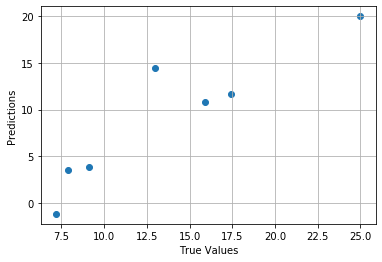

In [37]:
# Define PLS object
pls = PLSRegression(n_components=6)
# Fit
pls.fit(X2_train, y_train)

y_pred = pls.predict(X2_test)

# Cross-validation
y_cv = cross_val_predict(pls, X2_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Elastic Net

In [56]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

In [57]:
for a in alphas:
    model = ElasticNet(alpha=a).fit(X_train,y_train)   
    score = model.score(X_train, y_train)
    pred_y = model.predict(X_test)
    mse = mean_squared_error(y_test, pred_y)   
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))

Alpha:0.0001, R2:0.82, MSE:3.91, RMSE:1.98
Alpha:0.0010, R2:0.71, MSE:1.89, RMSE:1.38
Alpha:0.0100, R2:0.58, MSE:2.54, RMSE:1.59
Alpha:0.1000, R2:0.38, MSE:6.61, RMSE:2.57
Alpha:0.3000, R2:0.15, MSE:13.84, RMSE:3.72
Alpha:0.5000, R2:0.01, MSE:18.26, RMSE:4.27
Alpha:0.7000, R2:0.00, MSE:18.68, RMSE:4.32
Alpha:1.0000, R2:0.00, MSE:18.68, RMSE:4.32


In [64]:
model = ElasticNet(alpha=0.001).fit(X_train,y_train)   
score = model.score(X_train, y_train)
print("Train score: ", score)
pred_y = model.predict(X_test)


rmse = sqrt(mean_squared_error(y_test, pred_y))
r2 = r2_score(y_test, pred_y)
print("RMSE: ", rmse)
print("R^2_pred: ", r2)

Train score:  0.7114321578157426
RMSE:  1.3750068392311252
R^2_pred:  0.8345272986305754


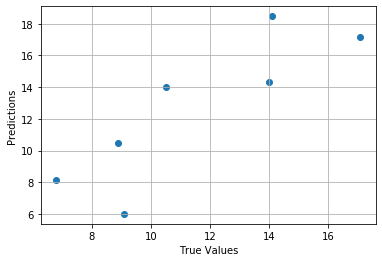

In [65]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Random Forest

In [86]:
#X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.15)
#X_train, X_test, y_train, y_test = train_test_split(principalComponents, y_df, test_size=0.15)


print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(28, 3648) (28, 1)
(6, 3648) (6, 1)
       0
19   7.7
21   6.1
31    14
11  17.4
5   15.9
27  14.9


In [84]:
y_test=np.ravel(y_test)
print(y_test.shape)
y_train=np.ravel(y_train)
print(y_train.shape)

(6,)
(28,)


RMSE:  3.4253221483409475
R^2:  0.4227862338513424 

[real, predictions]
[[19.9 19.79389600000039]
 [15.5 14.460439999999815]
 [7.9 9.055768000000073]
 [14.0 14.928896000000439]
 [7.2 15.140856000000044]
 [15.9 13.887735999999931]]


Text(0, 0.5, 'Predictions')

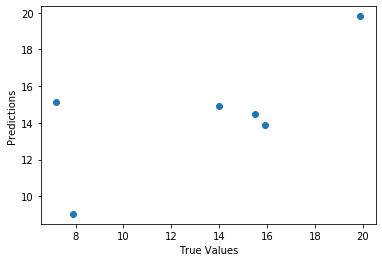

In [85]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 2500, max_depth=30, random_state = 42)
# Train the model on training data

rf.fit(X_train, y_train);

# Use the forest's predict method on the test data
predictions = rf.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("RMSE: ", rmse)
print("R^2: ", r2, "\n")

y_test= y_test.reshape((len(y_test), 1))
predictions=predictions.reshape((len(y_test), 1))
#print((y_test, predictions))

b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

# MultiOutput Random Forest

In [132]:
multi_y = concentration[:,1:-2]
print (multi_y.shape)
print (type(multi_y))
df_y= pd.DataFrame(multi_y)
print (type(df_y))

(24, 6)
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [153]:
X_train, X_test, y_train, y_test = train_test_split(x_df, df_y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(19, 1130) (19, 6)
(5, 1130) (5, 6)


In [134]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=650,
                                                          max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=30,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=650,
                                                

In [135]:
y_multirf = regr_multirf.predict(X_test)

In [136]:
print(y_test.shape)
print(y_multirf.shape)

(5, 6)
(5, 6)


In [137]:
rmse = sqrt(mean_squared_error(y_test, y_multirf))
r2 = r2_score(y_test, y_multirf)

print("R^2: ", r2)
print("RMSE: ", rmse)

R^2:  -1.2798201186343863
RMSE:  1.5231794557929577


In [138]:
b=np.append(np.around(y_test,3), np.around(y_multirf,3), axis=1)

print("[real, predictions]")
print(b)

[real, predictions]
[[6.160e+00 0.000e+00 3.630e-01 0.000e+00 6.000e-03 2.060e-01 8.711e+00
  2.880e-01 4.460e-01 2.870e-01 7.790e-01 1.910e-01]
 [6.120e+00 0.000e+00 3.200e-01 0.000e+00 5.000e-03 1.600e-02 8.009e+00
  2.150e-01 4.630e-01 8.500e-02 1.110e-01 1.440e-01]
 [1.253e+01 3.100e-01 2.500e-02 5.000e-02 5.600e-02 3.300e-02 7.822e+00
  2.570e-01 2.970e-01 1.650e-01 1.750e-01 2.170e-01]
 [1.800e-01 5.000e-01 1.110e+00 5.200e-02 1.500e-01 1.260e+00 4.830e-01
  3.630e-01 1.233e+00 2.260e-01 1.360e-01 9.710e-01]
 [1.290e+01 1.200e-01 5.200e-01 1.550e-01 5.200e-01 2.860e-01 6.898e+00
  3.360e-01 7.140e-01 1.420e-01 5.610e-01 2.290e-01]]


Text(0, 0.5, 'Predictions')

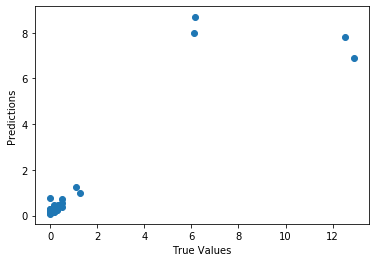

In [139]:
plt.scatter(y_test, y_multirf)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [141]:
y_pred=np.around(y_multirf,2)
y_pred[:,0]

array([8.71, 8.01, 7.82, 0.48, 6.9 ])

In [142]:
y_test[0].values

array([ 6.16,  6.12, 12.53,  0.18, 12.9 ])

In [143]:
print("real: ", y_test[0].values)
print("pred: ", y_pred[:,0])

real:  [ 6.16  6.12 12.53  0.18 12.9 ]
pred:  [8.71 8.01 7.82 0.48 6.9 ]


# PLS-2

100% completed
Suggested number of components:  33



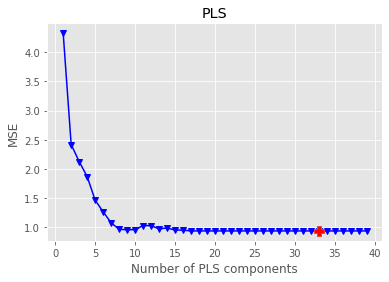

R2 calib: 1.000
R2 CV: 0.018
MSE calib: 0.000
MSE CV: 0.939


In [154]:
optimise_pls_cv(X_train, y_train, 40, plot_components=True)

In [155]:
# Define PLS object
pls = PLSRegression(n_components= 26)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)
# Calculate scores
score = r2_score(y_train, y_cv)
mse = mean_squared_error(y_train, y_cv)

print("R^2: ", score)
print("MSE: ", mse)

R^2:  0.018347253779067135
MSE:  0.9391318844120397


In [150]:
y_pred = pls.predict(X_test)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print(score_pred) #NAMMERDA
print(score_cv)

-4.070272705754876
0.36555579763038115


In [151]:
pd.DataFrame(np.round(y_pred, decimals=2))

,0,1,2,3,4,5
0,7.84,0.22,0.54,0.19,0.57,0.27
1,8.62,0.12,0.35,0.06,-0.12,-0.06
2,10.50,0.13,-0.61,0.45,0.15,-0.03
3,-0.28,0.42,1.56,-0.11,-0.34,0.95
4,9.93,0.09,0.29,-0.26,0.65,0.14


In [152]:
np.round(y_test, decimals=2)

,0,1,2,3,4,5
20,6.16,0.00,0.36,0.00,0.01,0.21
12,6.12,0.00,0.32,0.00,0.01,0.02
13,12.53,0.31,0.02,0.05,0.06,0.03
22,0.18,0.50,1.11,0.05,0.15,1.26
7,12.90,0.12,0.52,0.16,0.52,0.29
